### __Imports and installs__

In [1]:
# !pip install grad-cam
# !pip install timm

# import numpy as np
# from tqdm import tqdm
# import math

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter
# import torchvision
# import torchvision.transforms as transforms
# from torchvision import models

# from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image




In [2]:
from pathlib import Path
import subprocess
import requests
from tqdm import tqdm

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2 as T

from utils_dataset import CustomImageDataset
from utils_models import get_model, evaluate_model_accuracy
from utils_cam import generate_cams, print_cams
from utils_adversarial import get_centers


In [3]:
gpu_id = 0
device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### __Dataset__

In [4]:
squeezenet = get_model("squeezenet")
resnet50 = get_model("resnet50")
inception_v4 = get_model("inception_v4")
adv_inception_v3 = get_model("adv_inception_v3")

models = [squeezenet, resnet50, inception_v4, adv_inception_v3]

In [5]:
# Load ImageNet class labels corresponding to numbers
LABELS_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json'
labels_response = requests.get(LABELS_URL)
labels_dict = labels_response.json()

In [6]:
images_folder_path = Path('tf_to_pytorch_model/dataset/images')
label_file_path = Path('tf_to_pytorch_model/dataset/dev_dataset.csv')

# Check if the images folder exists; if not, clone the repository
if not images_folder_path.exists():
    repo_url = 'https://github.com/ylhz/tf_to_pytorch_model.git'
    try:
        subprocess.run(["git", "clone", repo_url], check=True)
        print(f"Repository cloned successfully.")
    except subprocess.CalledProcessError as e:
        print(f"Failed to clone repository: {e}")


In [7]:
dataset = CustomImageDataset(label_file_path, images_folder_path)

batch_size = 64 
num_workers = 4 

dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)

Processing Images: 100%|██████████| 24/24 [00:00<00:00, 74.95it/s]


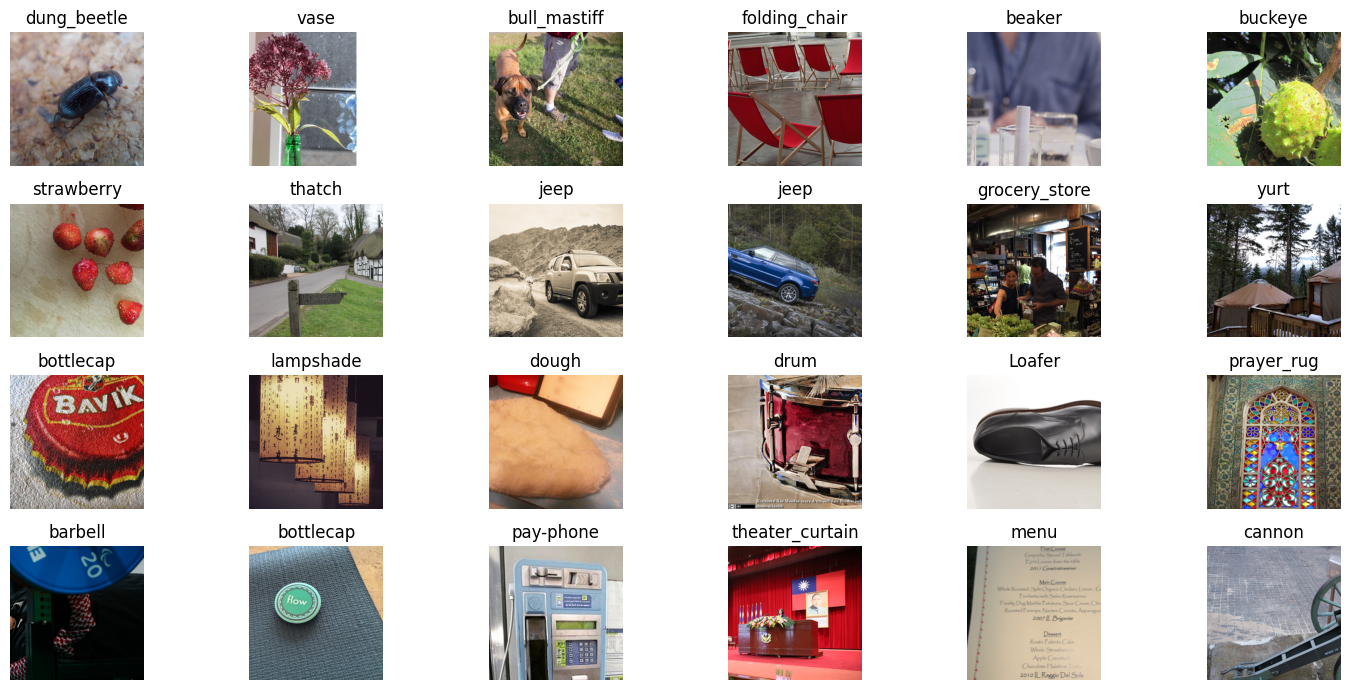

In [8]:
plt.figure(figsize=(15, 7))

# Take the first batch 
images, labels = next(iter(dataloader))
for i in tqdm(range(24), desc="Processing Images"):
    if i >= images.shape[0]:  
        break
    plt.subplot(4, 6, i + 1)
    img = images[i]
    img = img.permute(1, 2, 0) 
    plt.imshow(img)
    label = labels[i].item()  
    plt.title(labels_dict[str(label)][1])
    plt.axis('off')

plt.gcf().tight_layout()
plt.show()

In [9]:
for model in models:
    evaluate_model_accuracy(model, dataloader, device)

Evaluating: 100%|██████████| 16/16 [00:02<00:00,  5.43it/s]


Accuracy of squeezenet: 66.8%


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]


Accuracy of resnet50: 93.0%


Evaluating: 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]


Accuracy of inception_v4: 94.5%


Evaluating: 100%|██████████| 16/16 [00:03<00:00,  4.56it/s]


Accuracy of adv_inception_v3: 86.5%


### __Class Activation Maps__

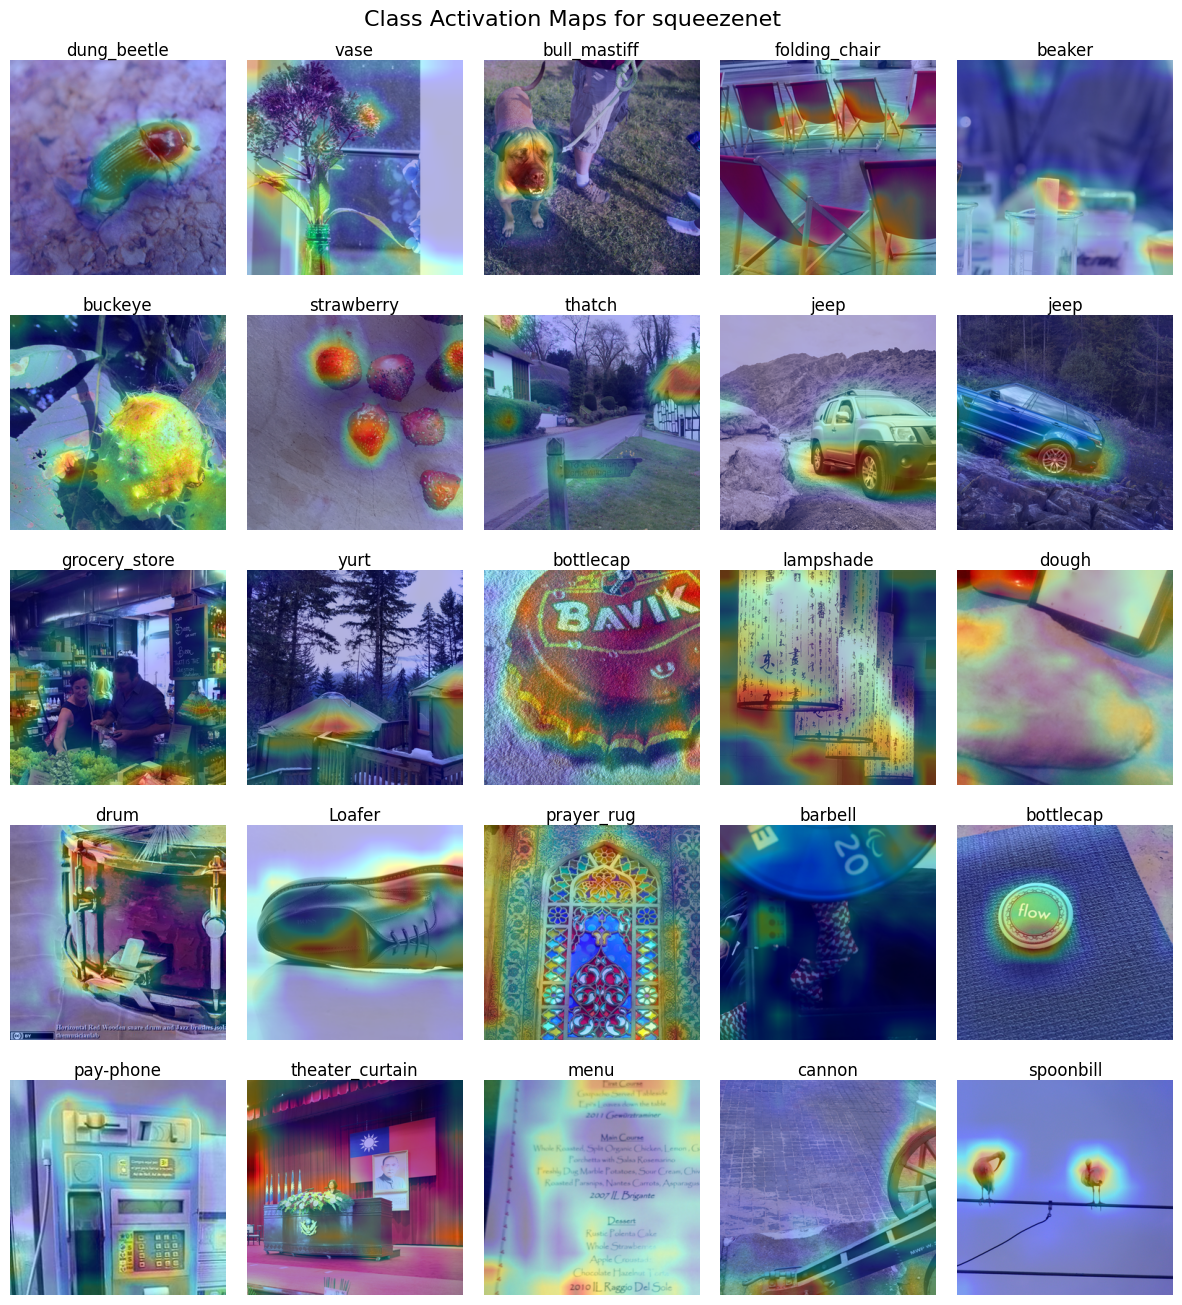

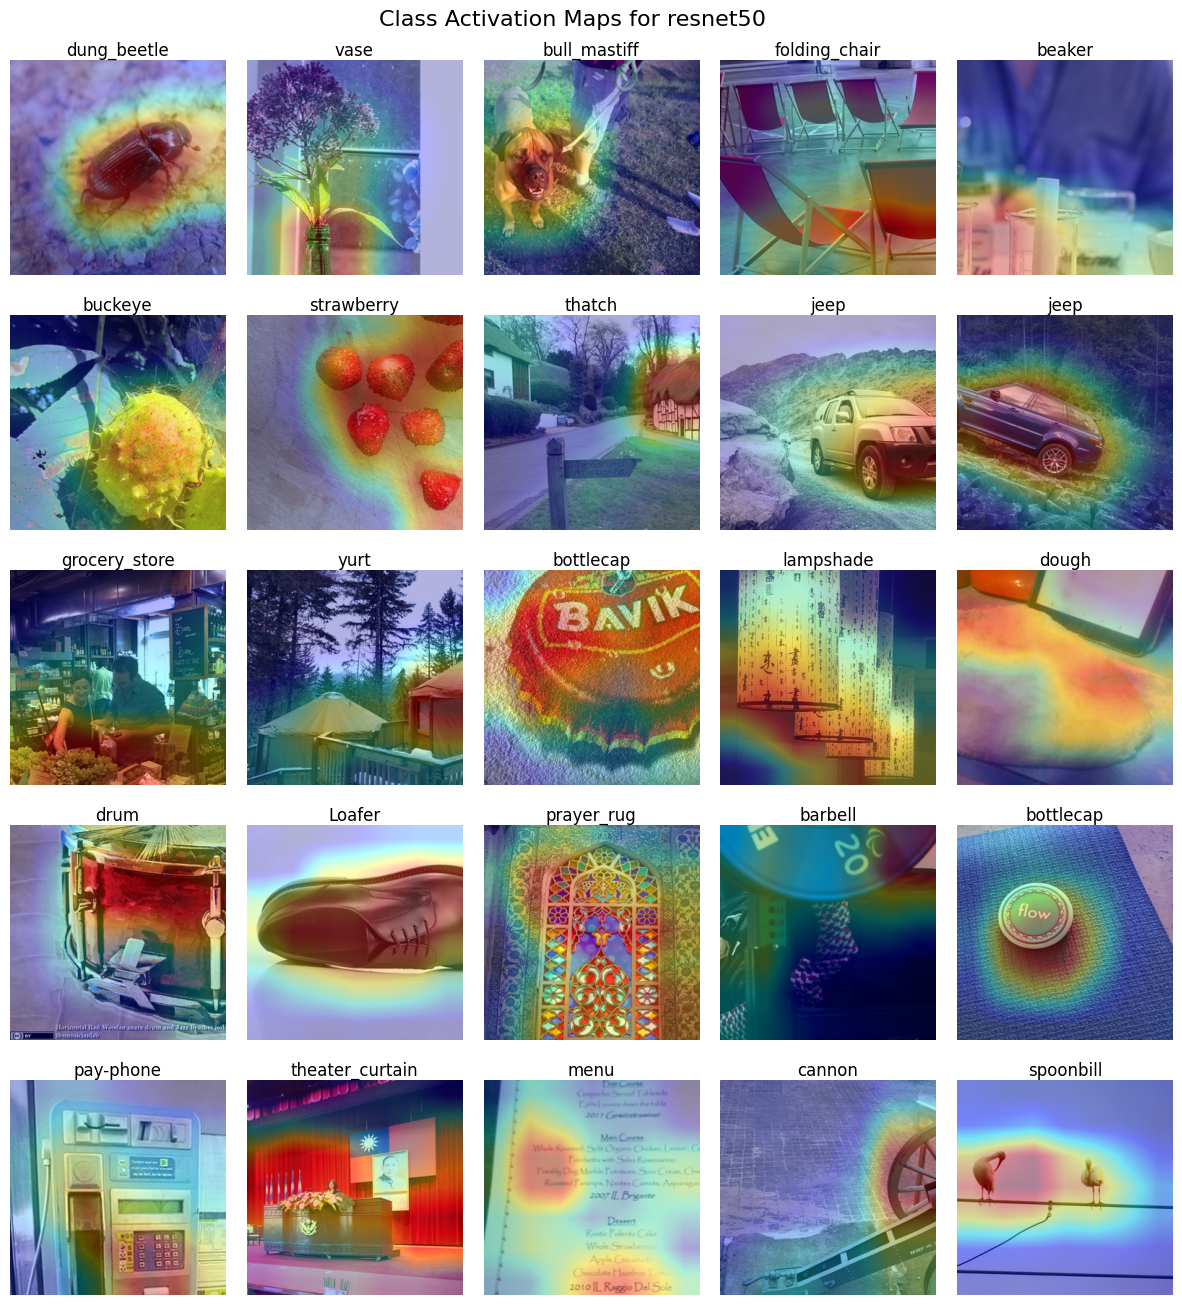

OutOfMemoryError: CUDA out of memory. Tried to allocate 68.00 MiB. GPU 0 has a total capacity of 11.91 GiB of which 64.69 MiB is free. Including non-PyTorch memory, this process has 11.84 GiB memory in use. Of the allocated memory 10.72 GiB is allocated by PyTorch, and 266.88 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [10]:
# Show grad cams for some images for each model
images, labels = next(iter(dataloader))
for model in models:
    model.to(device)
    grayscale_cam = generate_cams(model, images, labels)
    # with generate_cams(model, images, labels) as grayscale_cam:
    print_cams(model.name, grayscale_cam, images, labels, labels_dict)
    model.to('cpu')
    torch.cuda.empty_cache()
    del grayscale_cam



### __Local Maxima__

In [ ]:
# Generate grayscale cams for inception_v4 
grayscale_cam_inception_v4 = generate_cams(inception_v4, images, labels)

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):
    cam = grayscale_cam_inception_v4[i]
    ax.imshow(cam, cmap='gray')

    filtered_coordinates = get_centers(cam, ratio_threshold = 0.6, min_distance = 20)

    # Plot the filtered coordinates on the images
    ax.plot(filtered_coordinates[:, 1], filtered_coordinates[:, 0], 'r.')
    ax.set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
print(next(squeezenet.parameters()).device)

### __Main algorithm__

In [ ]:
def replace_pixels(xadv, xclean, center, method = "square", cam = None, threshold = None, side_length_square = None, side_length_threshold = None):

    if len(xadv.shape) == 4:
      xadv = xadv.squeeze()

    if len(xclean.shape) == 4:
      xclean = xclean.squeeze()

    if method == "square":

      _, h, w = xadv.shape
      grid_x, grid_y = torch.meshgrid(torch.arange(w), torch.arange(h))

      # Calculate distances from the center
      dist_x = torch.abs(grid_x - center[1])
      dist_y = torch.abs(grid_y - center[0])

      # Create mask for the square region around (x, y)
      mask = (dist_x <= side_length_square) & (dist_y <= side_length_square)

      # Expand the mask to have the same number of channels as B
      mask_expanded = mask.unsqueeze(0).expand_as(xadv)

      # Create a new tensor by combining values from A and B based on the mask
      result = torch.where(mask_expanded, xclean, xadv)

    elif method == "threshold":

      # Create coordinates grid
      h, w = cam.shape
      grid_x, grid_y = torch.meshgrid(torch.arange(w), torch.arange(h))

      # Calculate distances from the center
      dist_x = torch.abs(grid_x - center[1])
      dist_y = torch.abs(grid_y - center[0])

      # Create mask for the square region around (x, y)
      mask = (dist_x <= side_length_threshold) & (dist_y <= side_length_threshold) & (cam > threshold)

      # Expand the mask to have the same number of channels as A and B
      mask_expanded = mask.unsqueeze(0).expand_as(xadv)

      # Create a new tensor by combining values from A and B based on the mask
      result = torch.where(mask_expanded, xclean, xadv)

    return result.unsqueeze(0)

In [ ]:
def ADP(x_clean, y_true, model_name, model, ratio_threshold, min_distance, eps, T, alpha, beta, m, mean, std, cam_method = "normal", momentum = None, device = "cuda", use_zero_gradient_method = False, replace_method = "square"):

  y_true = y_true.to(device)

  if momentum != None:
    use_momentum = True
  else:
    use_momentum = False

  target_layer = get_target_layer(model_name, model)

  if cam_method == "normal":
    cam = GradCAM(model=model, target_layers=target_layer)

  elif cam_method == "++":
    cam = GradCAMPlusPlus(model=model, target_layers=target_layer)

  targets = [ClassifierOutputTarget(torch.argmax(y_true))]

  x_adv = torch.clone(x_clean).detach().requires_grad_(True)

  W, H = x_clean.shape[1], x_clean.shape[2]

  criterion = torch.nn.CrossEntropyLoss()

  normalized_clamp = Normalized_Clamp(mean, std, device)

  for t in range(0, T):

    x_adv.requires_grad_(True)

    g = 0

    if use_momentum:
      previous_g = 0

    M = cam(input_tensor=x_adv, targets=targets)

    max_cam = M.max()

    centers = get_centers(M[0], ratio_threshold, min_distance)

    for center in centers:

      for k in range(1, m+1):
        #x1 = int(max(center[0]-beta*k, 0))
        #x2 = int(min(center[0]+beta*k, W))
        #y1 = int(max(center[1]-beta*k, 0))
        #y2 = int(min(center[1]+beta*k, H))

        if not use_zero_gradient_method:

          x_drop = torch.clone(x_adv).detach()

          if replace_method == "square":
            x_drop.data = replace_pixels(x_drop.data, x_clean.data, center, "square", side_length_square = beta*k)

          elif replace_method == "threshold":
            x_drop.data = replace_pixels(x_drop.data, x_clean.data, center, "threshold", M[0], threshold = max_cam/(0.88**k), side_length_threshold = beta*m)

          #x_drop.data[:, x1:x2, y1:y2] = x_clean.data[:, x1:x2, y1:y2]
          x_drop = x_drop.detach()
          x_drop.requires_grad_(True)

          loss = criterion(model(x_drop)[0], y_true)
          loss.backward()

          grad = x_drop.grad.data
          g += grad

          x_drop.grad.zero_()

        elif use_zero_gradient_method:

          loss = criterion(model(x_adv)[0], y_true)
          loss.backward()

          grad = x_adv.grad.data

          if replace_method == "square":
            grad.data = replace_pixels(grad.data, torch.zeros_like(grad.data), center, "square", side_length_square = beta*k)

          elif replace_method == "threshold":
            grad.data = replace_pixels(grad.data, torch.zeros_like(grad.data), center, "threshold", M[0], threshold = max_cam/(0.88**k), side_length_threshold = beta*m)

          #grad[:, x1:x2, y1:y2] = 0
          g += grad

          x_adv.grad.zero_()

    g *= 1/(len(centers)*m)

    if use_momentum:
      g = momentum * previous_g + g / torch.mean(torch.abs(g), dim = (1,2,3), keepdim=True)

    x_adv_max = x_clean + eps
    x_adv_min = x_clean - eps

    with torch.no_grad():

      x_adv_max = normalized_clamp(x_adv_max)
      x_adv_min = normalized_clamp(x_adv_min)

      g_sign = g.sign()
      perturbed_x_adv = x_adv + alpha * g_sign
      x_adv = torch.max(torch.min(perturbed_x_adv, x_adv_max), x_adv_min)

      previous_g = torch.clone(g)

  return x_adv

In [ ]:
def MFGSM(x_clean, y_true, model_name, model, eps, T, alpha,mean, std, momentum = None, device = "cuda"):

  y_true = y_true.to(device)

  if momentum != None:
    use_momentum = True
  else:
    use_momentum = False

  x_adv = torch.clone(x_clean).detach().requires_grad_(True)

  criterion = torch.nn.CrossEntropyLoss()

  normalized_clamp = Normalized_Clamp(mean, std, device)

  if use_momentum:
    previous_g = 0

  g = 0

  for t in range(0, T):

    x_adv.requires_grad_(True)

    loss = criterion(model(x_adv)[0], y_true)
    loss.backward()
    g = torch.clone(x_adv.grad.data)
    x_adv.grad.zero_()

    if use_momentum:
      g = momentum * previous_g + g / torch.mean(torch.abs(g), dim = (1,2,3), keepdim=True)

    x_adv_max = x_clean + eps
    x_adv_min = x_clean - eps

    with torch.no_grad():

      x_adv_max = normalized_clamp(x_adv_max)
      x_adv_min = normalized_clamp(x_adv_min)

      g_sign = g.sign()
      perturbed_x_adv = x_adv + alpha * g_sign
      x_adv = torch.max(torch.min(perturbed_x_adv, x_adv_max), x_adv_min)

      previous_g = torch.clone(g)

  return x_adv

#### Example use

In [ ]:
x_clean = Preprocessing_Transform(mean, std, "squeezenet", "cpu")(X[4]).unsqueeze(0)
y_true = one_hot_y[4]

x_adv = ADP(x_clean, y_true, "squeezenet", squeezenet_cpu, ratio_threshold=0.6, min_distance=20, eps=0.274, T=10, alpha=0.5, beta=15, m=5, mean=mean, std=std, cam_method = "++", momentum = 0.8, device = "cpu", use_zero_gradient_method = True, replace_method = "square")
#x_adv = MFGSM(x_clean, y_true, "squeezenet", squeezenet_cpu, eps=0.274, T=50, alpha=0.5, mean=mean, std=std, momentum=0.8, device="cpu")

In [ ]:
transfer_x_adv = Preprocessing_Transform(mean, std, "inceptionv4", "cpu")(Depreprocessing_Transform(mean, std, "squeezenet")(x_adv.squeeze()))

In [ ]:
y_pred_squeezenet_before = torch.argmax(torch.nn.functional.softmax(squeezenet_cpu(x_clean)[0], dim=0))
y_pred_inceptionv4_before = torch.argmax(torch.nn.functional.softmax(inceptionv4_cpu(x_clean)[0], dim=0))

y_pred_squeezenet_after = torch.argmax(torch.nn.functional.softmax(squeezenet_cpu(x_adv)[0], dim=0))
y_pred_inceptionv4_after = torch.argmax(torch.nn.functional.softmax(inceptionv4_cpu(transfer_x_adv.unsqueeze(0))[0], dim=0))

print("True class: ", labels_dict[str(int(torch.argmax(one_hot_y[4])))][1])

print("Initial predicted class, Attack model: ", labels_dict[str(int(y_pred_squeezenet_before))][1])
print("Initial predicted class, Transfer model: ", labels_dict[str(int(y_pred_inceptionv4_before))][1])

print("New predicted class, Attack model: ", labels_dict[str(int(y_pred_squeezenet_after))][1])
print("New predicted class, Transfer model: ", labels_dict[str(int(y_pred_inceptionv4_after))][1])

### __Statistics__

In [ ]:
def get_accuracy(model, dataset_X, dataset_y):

  with torch.no_grad():
    y_pred = np.array(model(dataset_X).argmax(dim=1).detach().cpu())
  accuracy = np.mean((y_pred == dataset_y))

  return accuracy


TODO : clamp avec bonnes valeurs et adapter eps en conséquence (done!);, Essayer moyenner x_adv sur différents modèles !!
IDEES AMELIO : rescale dans algo (done), gradCAM (RDFIA) en + de gradCAM++ (done); threshold au lieu de région carrée pour régions dropout (done), tester en mettant le gradient à 0 dans les régions dropped out (done)

In [ ]:
X_adv_squeezenet = []

with torch.no_grad():
  input_dataset = Preprocessing_Transform(mean, std, "squeezenet", "cuda")(X)

squeezenet_cuda = get_model("squeezenet", "cuda")

for i in tqdm(range(len(X))):
    x_clean = input_dataset[i].unsqueeze(0)

    y_true = one_hot_y[i]

    # Generate the adversarial example
    x_adv = ADP(x_clean, y_true, "squeezenet", squeezenet_cuda, ratio_threshold=0.6, min_distance=20, eps=0.274,
                T=10, alpha=0.5, beta=15, m=5, mean=mean, std=std, cam_method="++", momentum=0.8, device = "cuda")


    X_adv_squeezenet.append(x_adv.squeeze())

X_adv_squeezenet_tensor = torch.stack(X_adv_squeezenet)

del input_dataset
del squeezenet_cuda

In [ ]:
squeezenet_cuda = get_model("squeezenet", "cuda")
with torch.no_grad():
  input_dataset = Preprocessing_Transform(mean, std, "squeezenet", "cuda")(X)
print("Initial accuracy Squeezenet: ", get_accuracy(squeezenet_cuda, input_dataset, y))
print("New accuracy Squeezenet: ", get_accuracy(squeezenet_cuda, X_adv_squeezenet_tensor, y))
del squeezenet_cuda
del input_dataset

In [ ]:
resnet50_cuda = get_model("resnet50", "cuda")
with torch.no_grad():
  input_dataset_initial = Preprocessing_Transform(mean, std, "resnet50", "cuda")(X)
  input_dataset_new = Preprocessing_Transform(mean, std, "resnet50", "cuda")(Depreprocessing_Transform(mean, std, "squeezenet")(X_adv_squeezenet_tensor))
print("Initial accuracy Resnet50: ", get_accuracy(resnet50_cuda, input_dataset_initial, y))
print("New accuracy Resnet50: ", get_accuracy(resnet50_cuda, input_dataset_new, y))
del resnet50_cuda
del input_dataset_initial
del input_dataset_new

In [ ]:
with torch.no_grad():
  input_dataset_initial = Preprocessing_Transform(mean, std, "inceptionv4", "cpu")(X)
  input_dataset_new = Preprocessing_Transform(mean, std, "inceptionv4", "cpu")(Depreprocessing_Transform(mean, std, "squeezenet")(X_adv_squeezenet_tensor))
print("Initial accuracy InceptionV4: ", get_accuracy(inceptionv4_cpu, input_dataset_initial, y))
print("New accuracy InceptionV4: ", get_accuracy(inceptionv4_cpu, input_dataset_new, y))
del input_dataset_initial
del input_dataset_new

In [ ]:
with torch.no_grad():
  input_dataset_initial = Preprocessing_Transform(mean, std, "adv_inceptionv3", "cpu")(X)
  input_dataset_new = Preprocessing_Transform(mean, std, "adv_inceptionv3", "cpu")(Depreprocessing_Transform(mean, std, "squeezenet")(X_adv_squeezenet_tensor))
print("Initial accuracy AdvInceptionV3: ", get_accuracy(adv_inceptionv3_cpu, input_dataset_initial, y))
print("New accuracy AdvInceptionV3: ", get_accuracy(adv_inceptionv3_cpu, input_dataset_new, y))
del input_dataset_initial
del input_dataset_new